# Overview

This week we will go back to networks, and we will learn about community detection. 

Here is the plan:

* __Part 1__: Learn about Community Detection with a lecture from Sune. Then do an exercise related to the famous [Zachary Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).
* __Part 2__: Learn how to compare network communities, using _normalized [mutual information](https://en.wikipedia.org/wiki/Mutual_information)_.
* __Part 3__: Apply community detection to the GME network.


# Part 1: Community detection.

Now that we have learnt about text analysis, it is time to go back to our GME network! We will start by learning about community detection with a lecture from Sune.

> **_Video Lecture_**: Communities in networks. 

You can watch the 2015 video [here](https://youtu.be/06GL_KGHdbE/)

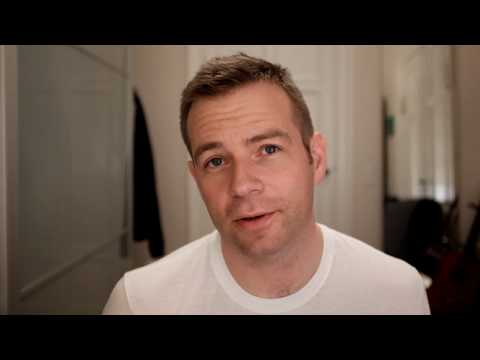

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

> **_Reading_**: [Chapter 9 of the NS book.](http://networksciencebook.com/chapter/9). You can skip sections 9.3, 9.5 and 9.7. 



_Exercise 1: Zachary's karate club_: And now, the idea is to put a bit into practice the concept of community detection. In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 



In [1]:
import networkx as nx
import netwulf as nw

In [2]:
karate_G = nx.karate_club_graph()

> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>

In [3]:
import numpy as np

green = np.array([1,2,3,4,5,6,7,8,11,12,13,14,17,18,20,22]) - 1 #0 indexing
purple = np.array([9,10,15,16,19,21,23,24,25,26,27,28,29,30,31,32,33,34]) - 1

colors = dict(list(zip(green,['green']*len(green))) + list(zip(purple, ['purple']*len(purple))))

nx.set_node_attributes(karate_G, colors, 'color')

In [45]:
karate_G_visualization = nw.visualize(karate_G, plot_in_cell_below=True)

<img src="Graphs/karate_graph.png"></img>

<img src="https://github.com/lalessan/comsocsci2021/raw/master/files/karate.png" alt="Drawing" style="width: 800px;"/>

> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [4]:
def calculate_modularity(graph:nx.Graph, partitions:list):
    '''
        graph: Networkx Graph
        partitions: List of partitions. Each partition should be a set of nodes in the graph
    '''
    L = graph.number_of_edges()

    M = 0
    for p in partitions:
        kc = sum(dict(graph.degree(p)).values())
        partition = graph.subgraph(p)
        Lc = partition.number_of_edges()
        M += (Lc/L) - (kc/(2*L))**2
    
    return M

> 3. Explain in your own words the concept of _modularity_. 

The concept of *modularity* descripes how well a suggested partitioning of a graph is compared to a random graph.
I.e. if the suggested partitioning is just random or if it actually could originate from real communities in the network.

> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.


In [5]:
partitions = nx.get_node_attributes(karate_G, 'club')
partition_labels = set(partitions.values())
communities = {label: set() for label in partition_labels}
for n, p in partitions.items():
    communities[p].add(n)

calculate_modularity(karate_G, communities.values())

0.3582347140039447

In [6]:
nx.algorithms.community.quality.modularity(karate_G, communities.values())

0.3582347140039448

In [7]:
#Example from book
G = nx.Graph()
green = [(0, {'color': 'green'}), (1, {'color': 'green'}), (2, {'color': 'green'}), (3,{'color': 'green'}), (4, {'color': 'green'})]
purple = [(5,{'color': 'purple'}), (6,{'color': 'purple'}), (7,{'color': 'purple'}), (8,{'color': 'purple'})]
G.add_nodes_from(green+purple)

green_edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,4), (3,4), (4,5)]
purple_edges = [(5,6), (5,7), (5,8), (6,7), (7,8)]
G.add_edges_from(green_edges+purple_edges)

In [8]:
G_partitions = nx.get_node_attributes(G, 'color')
G_partition_labels = set(G_partitions.values())
G_communities = {label: set() for label in G_partition_labels}
for n, p in G_partitions.items():
    G_communities[p].add(n)

calculate_modularity(G, G_communities.values())

0.41124260355029596

In [9]:
nx.algorithms.community.quality.modularity(G, G_communities.values())

0.41124260355029585

> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network. 
>       * __b.__ Consider the list of network edges. Create two lists: the list of source nodes and target nodes. (e.g. edges = [(1,2),(3,4)], sources = [1,3], targets = [2,4])
>       * __c.__ Concatenate the list of source nodes and target nodes into a unique list (e.g. [1,2,3,4]). This is the list of _stubs_ (see the [Wikipedia page](https://en.wikipedia.org/wiki/Configuration_model) for the definition of stub).
>       * __d.__ Shuffle the list of stubs. Build a set of edges (tuples), by connecting each element in the list of shuffled stubs with the following element (e.g. [4,1,2,3] --> [(4,1),(2,3)])
>       * __e.__ Remove all the original network edges from your network. Add all the new _shuffled_ edges you created in step __d.__


In [10]:
import random

def compute_configuration_model(graph):
    configuration_model = graph.copy()
    sources = [s for s,t in karate_configuration.edges()]
    targets = [t for s,t in karate_configuration.edges()]
    stubs = sources + targets

    random.shuffle(stubs)
    random_edges = []
    while len(stubs) >= 2:
        random_edges.append((stubs.pop(), stubs.pop()))

    configuration_model.remove_edges_from(list(configuration_model.edges()))
    configuration_model.add_edges_from(random_edges)

    return configuration_model

In [11]:
import random

karate_configuration = karate_G.copy()
sources = [s for s,t in karate_configuration.edges()]
targets = [t for s,t in karate_configuration.edges()]
stubs = sources + targets

random.shuffle(stubs)
random_edges = []
while len(stubs) >= 2:
    random_edges.append((stubs.pop(), stubs.pop()))

karate_configuration.remove_edges_from(list(karate_configuration.edges()))
karate_configuration.add_edges_from(random_edges)

> 6. Is the degree of the nodes in your original and the configuration model network the same? Why? . __Note 1:__ With this algorithm you may obtain some self-loops. Note that [a self-loop should add two to the degree](https://en.wikipedia.org/wiki/Loop_(graph_theory)#:~:text=For%20an%20undirected%20graph%2C%20the,adds%20two%20to%20the%20degree.&text=In%20other%20words%2C%20a%20vertex,not%20one%2C%20to%20the%20degree.). __Note 2:__ With this algorithm, you could also obtain repeated edges between the same two nodes. Only NetworkX [MultiGraph](https://networkx.org/documentation/stable/reference/classes/multigraph.html) allow for repeated edges, while regular [Graph](https://networkx.org/documentation/stable/reference/classes/graph.html?highlight=graph%20undirected#networkx.Graph) do not, meaning you will not be able to account for multi-edges when you have a regular Graph. (_Optional_: if you want to implement a configuration model without self-loops and multi-edges, you can try out the [double_edge_swap](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html) algorithm)


In [12]:
karate_G.degree

DegreeView({0: 16, 1: 9, 2: 10, 3: 6, 4: 3, 5: 4, 6: 4, 7: 4, 8: 5, 9: 2, 10: 3, 11: 1, 12: 2, 13: 5, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 5, 24: 3, 25: 3, 26: 2, 27: 4, 28: 3, 29: 4, 30: 4, 31: 6, 32: 12, 33: 17})

In [13]:
karate_configuration.degree

DegreeView({0: 15, 1: 9, 2: 8, 3: 5, 4: 3, 5: 4, 6: 4, 7: 4, 8: 5, 9: 2, 10: 3, 11: 1, 12: 2, 13: 5, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 1, 23: 5, 24: 3, 25: 3, 26: 2, 27: 4, 28: 3, 29: 4, 30: 4, 31: 6, 32: 9, 33: 15})

In [14]:
sum(dict(karate_G.degree).values())

156

In [15]:
sum(dict(karate_configuration.degree).values())

146

They are note the same. This makes sense, as the configuration model 

> 7. Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.


In [37]:
N = 1000

partitions = nx.get_node_attributes(karate_G, 'club')
partition_labels = set(partitions.values())
communities = {label: set() for label in partition_labels}
for n, p in partitions.items():
    communities[p].add(n)

modularities = []

for _ in range(N):
    configuration_model = compute_configuration_model(karate_G)
    modularities.append(calculate_modularity(configuration_model, communities.values()))

> 8. Compute the average and standard deviation of the modularity for the configuration model.


In [38]:
np.mean(modularities)

-0.00032107803892627695

In [39]:
np.std(modularities)

0.054928744486309966

> 9. Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 


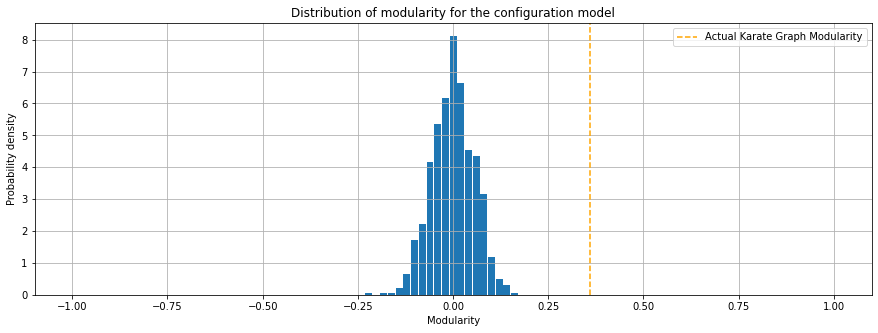

In [48]:
import matplotlib.pylab as plt

karate_modularity = calculate_modularity(karate_G, communities.values())

bins = np.linspace(-1, 1, 100)
hist, hist_edges = np.histogram(modularities, bins=bins, density=True)
x = (hist_edges[1:]+hist_edges[:-1])/2

fig, ax = plt.subplots(figsize=(15,5))
width = bins[1]-bins[0]
ax.bar(x, hist, width=width*0.9)
ax.axvline(karate_modularity, linestyle='--', c='orange', label='Actual Karate Graph Modularity')
ax.grid()
ax.set_title('Distribution of modularity for the configuration model')
ax.set_xlabel('Modularity')
ax.set_ylabel('Probability density')
plt.legend()
plt.show()

> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?


The modularity of the configuration model is normally distributed around 0. The normal distribution comes from the large N (central limit theorem). This shows that the modularity of a randomized equivalent to the karate club split network partion would be around 0 and that the modularity of the original karate club network partitioning therefore has a higher modularity than random. As such, the club split is indeed a split that shows community grouping which cannot be ascribed to randomness.   

> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?


> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

# Part 2: Comparing partitions

[Section 9.6](http://networksciencebook.com/chapter/9#testing) of the Network Science book dicusses how to test the accuracy of community detection algorithms on networks with predefined community structure. This involves measuring the similarity between the predefined structure and the communities identified by a given community detection algorithm. There are many ways for comparing partitions (for an extensive review, see [this article](http://staff.ustc.edu.cn/~zwp/teach/MVA/cluster_validation.pdf)). The book introduces the widely used _normalized mutual information_ (eq. 9.19). We are going to learn more about it and implemement it!

First, let's dig a bit deeper into the definition of __Mutual Information__ between two discrete variables $X$ and $Y$. 

The mutual information is the reduction in uncertainty about variable $X$, After observing a second random variable $Y$. It is measured as the difference between the entropy of $X$, $H(X)$ (which measures its uncertainty), and the conditional entropy of $X$ given $Y$, $H(X|Y)$ (which measures the uncertainty about $X$ after observing $Y$).

$I(X;Y)=H(X)−H(X|Y)$

If you are not familiar with the concepts of entropy and conditional entropy, or have any doubt about the definition of mutual information, I suggest to carefully read [this page](http://www.scholarpedia.org/article/Mutual_information). If you are someone who learns by doing, the next exercise should help!

_Exercise 2: Mutual Information:_ In the exercise above, we computed the confusion matrix to compare the communities found by the Louvain method with the "club" split. In this exercise, we will compare the two using the Normalized Mutual Information (see eq. 9.19 in your Network Science Book).

> 1. Write a function that, given as input a list of discrete items, returns a dictionary containing the probability of each unique value in the list. For example, given as input the list $[ 1,1,0,1,2]$, the function should return the following dictionary $\{1:0.6,0:0.2,2:0.2\}$.
> 2. Loop through the nodes of your Zachary Karate Club network. For each node, find the corresponding club (either _"Mr Hi"_ or _"Officer"_) and store it in a list $l_1$. Compute the probability $p(x)$ of each club $x$ using the function you computed above. 
> 3. Loop again through the nodes of your Zachary Karate Club (in the same order as you did in step 1.). For each node, find the corresponding Louvain community, and store it in a list $l_2$. Compute the probability $p(y)$ for each Louvain community $y$ using your function. 
> 4. Loop again through the nodes of your Zachary Karate Club (in the same order!). This time, build a list of tuples $l_3$, such that the first value in the tuple is club and the second is the Louvain community. Compute the probability $p(x,y)$ for each tuple $(x,y)$ in your list using the function you wrote in step 1.. 
> 5. Compute the Shannon entropy of the Karate Club split. Remember that the entropy of a variable $X$ is defined as $H(X) = -\sum_x p(x)log(p(x))$. Here the sum runs over the two clubs: _"Mr Hi"_ and _"Officer"_. You need the probabilities you computed in step 2.
> 6. Compute the entropy of the Louvain community partitioning $H(Y) = -\sum_x p(y)log(p(y))$. Here the sum runs over the communities found by the Louvain method. You need the probabilities you computed in step 3.
> 7. Compute the conditional entropy $H(X|Y) = - \sum_{x,y} p(x,y)\cdot log \frac{p(x,y)}{p(y)}$, where the sum runs over all possible combinations of clubs and communities. You need the probabilities you computed in steps 2. and 4.
> 8. Now, compute the mutual information $I(X;Y) = H(X) - H(X|Y)$. Compare your result with the results you would obtain applying the scikit-learn function [mutual_info_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html). You should pass the lists $l_1$ and $l_2$ as inputs to your function.
> 9. Compute the normalized mutual score: $I_n(X;Y) = \frac{I(X;Y)}{\frac{1}{2}H(X) + \frac{1}{2}H(Y)}$.Compare your result with the results you would obtain applying the scikit-learn function [normalized_mutual_info_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html). 
> 10. What is the point of normalizing the mutual information through dividing it by ${\frac{1}{2}H(X) + \frac{1}{2}H(Y)}$?
> 11. We will now perform another randomization test. Shuffle the club split node labels (e.g assign a new group to each node, but keep the size of the "Officer" and "Mr Hi" groups constant). Measure the _normalized mutual information_ with the Louvain communities using the procedure above. Repeat the procedure $1000$ times and plot the distribution of the "random" _normalized mutual information_.
> 12. Based on your analysis, what can you conclude about the similarity of the Louvain communities and the actual club split? Why do you think I asked you to run a randomization test?

# Part 3: communities in the GME network.

Finally, lets' apply community detection to our favourite network: the GME network. In the following, consider the undirected version of the graph.

> _Exercise 3_: Community detection on the GME network. 
> * Consider the GME network you built in [Week 3](https://nbviewer.jupyter.org/github/lalessan/comsocsci2021/blob/master/lectures/Week3.ipynb), part 3.
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * If you are curious, you can also try the *Infomap* algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in [advanced topics 9B](http://networksciencebook.com/chapter/9#advanced-9b).
> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.

> _Exercise 4_ (*Optional*): Understanding communities using text analysis. 
> 
> * We want to find out which words are important for each community, so we're going to create N large documents, where N is the number of communities you have found in exercise 9. Tokenize the submissions, and combine the tokens into one long list including all the posts submitted by the members of the same community. 
> * Compute the TF-IDF for each community. 
> * Create a word-cloud for each community. Do they help interpreting the communities you have found?